In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
#저장용 파일명을 저장할 변수
model_path="의료비용.keras"  #이전에는 hd5형식 => keras에서 제공하는 저장함수를 이용해서 저장
history_path="의료비용.bin"

In [ ]:
def load():
  print("1.데이터 로딩")
  try:
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data2/insurance.csv")
  except FileNotFoundError:
    print("파일을 찾을 수 없습니다")
    return

  print("데이터 정보")
  print(df.info())
  print(df.describe())
  return df


#df = load()


In [ ]:
#차트-히스토그램을 그려서(의료비용을 예측하려고)
def showChart1(df):
  plt.figure(figsize=(10,6))
  sns.histplot(df["charges"], bins=60, kde=True)
  plt.title('Distribution of Medical Charges')
  plt.xlabel('Medical Charges')
  plt.ylabel('Frequency')
  plt.show()

#showChart1(df)







In [ ]:
#전처리를 한다 => object => 라벨인코딩 또는 원핫인코딩을 해야 한다
def preprocessing(df):
  categorical_features=['sex', 'smoker', 'region']
  df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
  """
  drop_first=True - 원핫인코딩 하는데 첫번째 컬럼을 만들지 마라

  성별 : sex_male, sex_female        => male
          1            0                True
          0            1                False

  대중소 : large middle small        => middle small
            1     0      0               0      0
            0     1      0               1      0
            0     0      1               0      1
  다중공선성 문제를 막기 위해서 -> 과대적합을 방지하기 위해서
  결국 다 같은건데 수학적으로 의미가 같은데 다른데이터로 처리되면서 발생하는 문제들
  drop_first=True 을 주면 과대적합을 피하는데 도움이 된다.
  """
  print(df_encoded.columns)

  #표준화 또는 정규화를 해야 한다. - 딥러닝,서포트벡터머신은 필수다, 과대적합을 막기위해 필요하다
  #특정 특성의 값이 너무 클 경우에 중요한 특성으로 인식될 수 있다. 이걸 막기 값을 일정범위내로
  #맞춘다.  0~1 사이로
  numerical_features = ['age', 'bmi', 'children']
  df_encoded[numerical_features] = (df_encoded[numerical_features] -  \
                                    df_encoded[numerical_features].mean()) /   \
                                    df_encoded[numerical_features].std()

  print(df_encoded.head())
  print(df_encoded.describe())
  return df_encoded


#df = preprocessing(df) ################################ 이부분서 return값 안받았음




In [ ]:
#결측치 이상치등등 확인도 해야 한다.
def data_load(df): #데이터 분할
  #1. input 테이터와 labels 데이터를 나누자
  X = df.drop('charges', axis=1) # 해당필드가 삭제된 데이터를 반환한다
  y = df['charges'] #해당 열만 복사한다

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  print("훈련셋 크기 ", X_train.shape, y_train.shape)
  print("테스트셋 크기 ", X_test.shape, y_test.shape)

  return {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}
  #반환타입이 dict임

df_processed = preprocessing(df)
data = data_load(df_processed)

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')
        age       bmi  children      charges  sex_male  smoker_yes  \
0 -1.438227 -0.453151 -0.908274  16884.92400     False        True   
1 -1.509401  0.509431 -0.078738   1725.55230      True       False   
2 -0.797655  0.383164  1.580335   4449.46200      True       False   
3 -0.441782 -1.305043 -0.908274  21984.47061      True       False   
4 -0.512957 -0.292447 -0.908274   3866.85520      True       False   

   region_northwest  region_southeast  region_southwest  
0             False             False              True  
1             False              True             False  
2             False              True             False  
3              True             False             False  
4              True             False             False  
                age           bmi      children       charges
count  1.

In [ ]:
#모델 또는 네트워크 구축
def getModel(): #적절한 모델 객체만 만들면 된다.  처음 레벨에는 input_shape 라고 해서 입력데이터의
                #크기가 필요했음, 지금은 필요없음
    tf.random.set_seed(42)
    model = keras.Sequential([
        layers.Dense(128, activation='relu'), # 128 dl 층을 끝내고 나오면 가중치 개수
        #이 값이 너무 크면 모델이 크다고 표현하고 과대적합이 될 수 있다
        #너무 작으면 과소적합이 될 수 도 있다
        layers.Dense(64, activation='relu'),
        layers.Dense(1) #회귀이므로 결과 하나만 예측을 하면 된다.
    ])

    model.compile( optimizer = tf.keras.optimizers.RMSprop(0.001),  #옵티마이저 정밀 제어
                   loss ='mse', #평균제곱오차 ,
                   metrics = ['mae'] #평균절대오차
                   )
    model.summary()
    return model

#model = getModel()


In [ ]:
def study(model, data): #실제 학습하기

  #조기종료 -> 학습을 계속 반복시켜놓고 10, 20-, 40,.............. 많이 돌려놓고
  #가중치가 더 좋아지지 않으면 학습을 멈추게 한다
  #monitor='val_loss' 손실값 감시
  #patience=10  인내심, 바로 멈추는것이 아니고 나빠지고 있지만 10번쯤은 더 돌려봐라
  #restore_best_weights=True 좋았던때로 가중치를 돌려놔라
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  history = model.fit(data["X_train"], data["y_train"],
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[early_stop],
                      verbose=2)
  model.save(model_path) #학습한 모벨 저장하기
  with open(history_path, "wb") as f:
    pickle.dump(history.history, f)


In [ ]:
def evaluate(data): #예측해볼때 데이터 필요
  model = keras.models.load_model(model_path)
  with open(history_path, "rb") as f:
    history = pickle.load(f)

  hist = pd.DataFrame(history)
  plt.figure(figsize=(10, 6))
  plt.plot(hist.index+1, hist['mae'], label='Training Error')
  plt.plot(hist.index+1, hist['val_mae'], label='Validation Error')
  plt.xlabel('Epoch')
  plt.ylabel('Meab Abs Error')
  plt.legend()
  plt.show()

  #모델 펴가및 예측 - 딥러닝에서는 결정계수를 사용하지 않고 mae를 사용한다
  #오차평균을 주로 사용한다
  liss, mae = model.evaluate(data["X_test"], data["y_test"])
  print("평균절대오차 : ", mae)
  """
  딥러닝에서는 평균절대오차를 모델 평가에 이용을 한다.
  실제값의 단위가 10000 임 그러면 오차가 4000대가 넘었다면 큰거지만
  실제값의 단위가 100000 이나 1000000이라면 정확하게 그러면 오차가 4000대가 넘었다면 작은거다
  적중률은 원래데이터에 따라 달라진다
  """
  test_prediction = model.predict(data["X_test"]).flatten() #예측하기
  plt.figure(figsize=(10,6))
  plt.scatter(data["y_test"], test_prediction) #산포도를 그린다. 실제값과 예측값으로
  plt.xlabel("True values") #x축이 실제값
  plt.ylabel("Prediction values")   #y축이 기대치
  plt.plot( [-100, 100000], [-100, 100000], c='red', linestyle='--')#선그림
  plt.title("True value vs Predictions")
  plt.show()


1.데이터 로딩
데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  

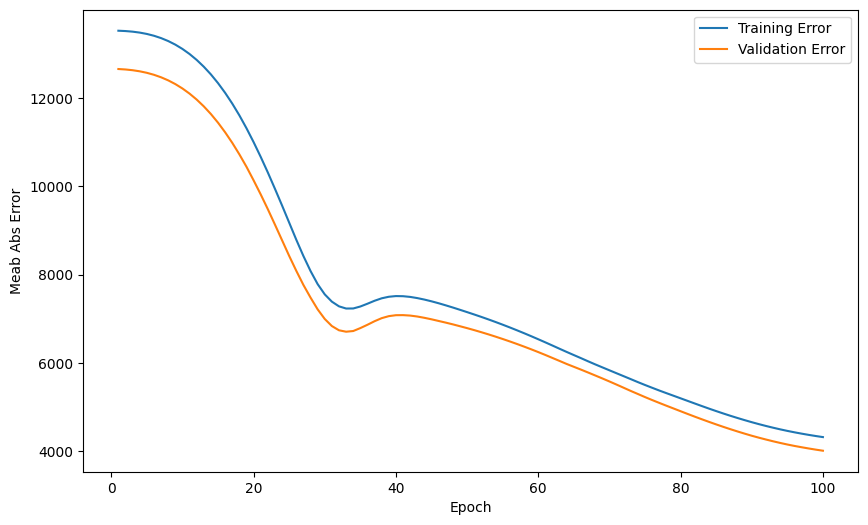

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32127132.0000 - mae: 4175.3086  
평균절대오차 :  4250.6455078125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


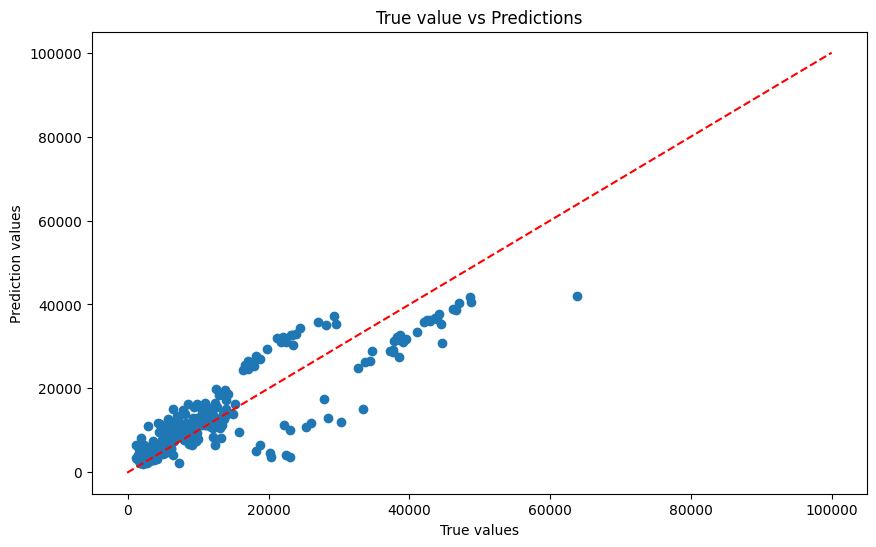

In [ ]:
#함수들 호출하기
df = load()
#showChart1(df)
df = preprocessing(df)
data = data_load(df)
#model = getModel()
#study(model, data)
evaluate(data)
